## Training the Stable Baselines agents using Protected RMSCA environment

In [1]:
import os
import gym
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Stable Baselines

In [2]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3, DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common import results_plotter

stable_baselines3.__version__

'1.8.0'

## Environment imports

In [3]:
# from optical_rl_gym.envs.rmcsa_env_dpp import RMCSADPPEnv
from optical_rl_gym.envs.rmcsa_env import SimpleMatrixObservation

## Define a callback function

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
        How often we check for improved model (in number of steps)
    :param log_dir: (str)
        Path to the folder where the model will be saved.
        It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
        Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        
    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward: {mean_reward:.2f}")
                    
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    
                if self.verbose > 0:
                    clear_output(wait=True)
                    
        return True

## Setting up the environment

The parameters are set as in the [this work](https://doi.org/10.1364/NETWORKS.2018.NeW3F.5).

In [5]:
topology_name = 'nsfnet_chen'
k_paths = 5
file_path = f'../topologies/{topology_name}_{k_paths}-paths_6-modulations.h5'

with open(file_path, 'rb') as f:
    topology = pickle.load(f)
    
monitor_info_keywords = ('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate', 'episode_failure_slots', 'episode_failure_disjointness', 'episode_failure_crosstalk')

env_args = dict(
  topology=topology,
  episode_length=1000,
  load=50,
  # mean_service_holding_time=10800.0,
  num_spectrum_resources=80,
  num_spatial_resources=7,
  # modulation_formats={}, # some thing
  # worst_xt={}, # some thing
  # node_request_probabilities={}, # some thing
  # bit_rate_selection="continous",
  # bit_rates=[], # some thing
  # bit_rate_probabilities=[], # some thing
  # bit_rate_lower_bound=25,
  # bit_rate_higher_bound=100,
  seed=10,
  # allow_rejection=True,
  # reset=True,
  channel_width=12.5,
)

## Creating the monitors and agent

In [6]:
# Create log dir
log_dir = "tmp/rmcsadpp-ppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=1)

env = gym.make('RMCSADPP-v0', **env_args)

# uses a matrix observation
env = SimpleMatrixObservation(env)

# logs will be saved in log_dir/monitor.csv
# in our case, on top of the usual monitored metrics, we also monitor service and bit rate blocking rates
env = Monitor(env, log_dir + 'training', info_keywords=monitor_info_keywords)
# for more information about the Monitor wrapper, please refer to the Stable Baselines documentation
# https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# here goes the arguments for the policy network to be used
# we are using a simple Multi Layer Perceptron (MLP) with 5 hidden layers with 128 neurons each
# we are using the default activation function (ReLU) and the default output activation function (None)
policy_args = dict(
  net_arch=[128] * 5 # 5 hidden layers with 128 neurons each
)

# create the agent
# we are using the Proximal Policy Optimization (PPO) algorithm with the Multi Layer Perceptron (MLP) policy network
# the agent will be trained for 10^6 steps
# we are using a discount factor of 0.95
# we are using a learning rate of 10^-6
agent = PPO(MlpPolicy, env, verbose=0, tensorboard_log="./tb/PPO-RMCSADPP-v0/", policy_kwargs=policy_args, gamma=0.95, learning_rate=10e-6)

## Training the agent

In [7]:
trained = agent.learn(total_timesteps=1000000, callback=callback)

Num timesteps: 1001000
Best mean reward: -498.48 - Last mean reward: -504.84


## Plotting the training progress

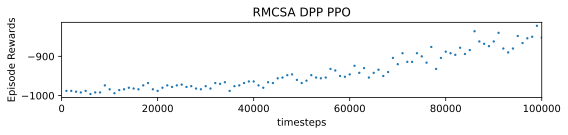

In [8]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "RMCSA DPP PPO")

## Plotting results

In [9]:
training_data = pd.read_csv(log_dir + 'training.monitor.csv', skiprows=1)
training_data.describe()

,r,l,t,episode_service_blocking_rate,episode_bit_rate_blocking_rate,episode_failure_slots,episode_failure_disjointness,episode_failure_crosstalk
count,1001.000000,1001.0,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,-563.428571,1000.0,30969.216254,0.781714,0.914131,70.079920,0.449903,0.002059
std,138.255015,0.0,14647.200734,0.069128,0.027667,18.473105,0.077784,0.011026
min,-996.000000,1000.0,1.689402,0.715000,0.883709,14.000000,0.373000,0.000225
25%,-542.000000,1000.0,35867.621571,0.747000,0.899871,65.000000,0.411000,0.000341
50%,-514.000000,1000.0,38464.605218,0.757000,0.904723,74.000000,0.423000,0.000522
75%,-494.000000,1000.0,39430.072350,0.771000,0.910866,82.000000,0.439000,0.001034
max,-430.000000,1000.0,41075.052369,0.998000,0.999144,117.000000,0.717000,0.274000


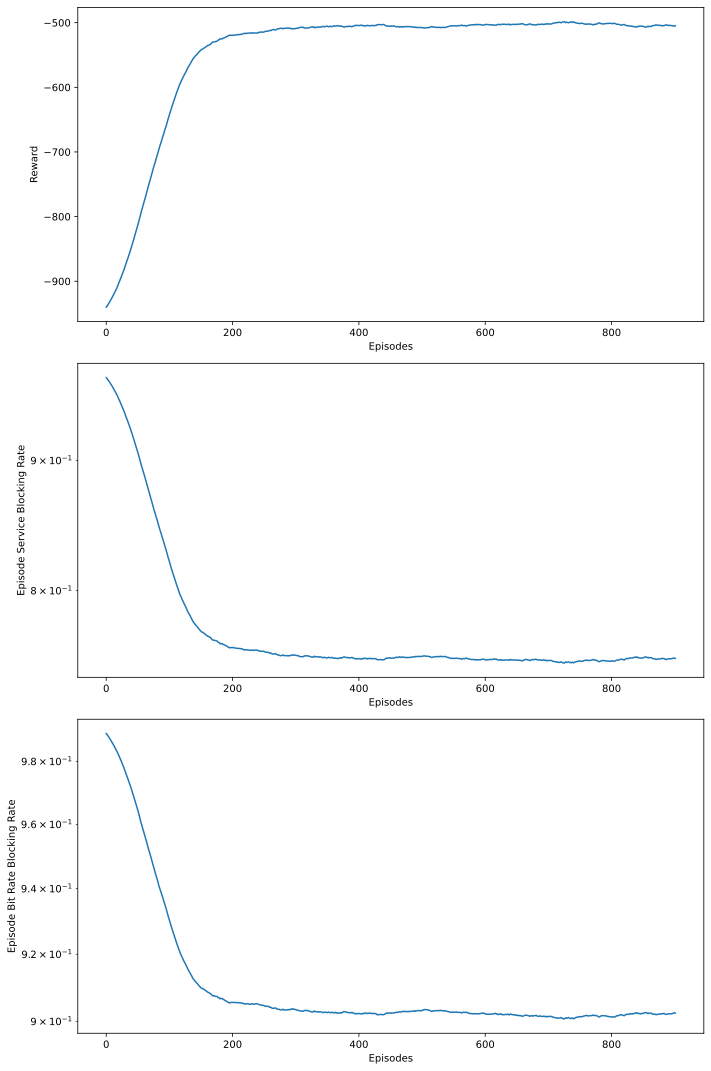

In [10]:
plotting_average_window = 100

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

ax1.plot(np.convolve(training_data['r'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward')

ax2.semilogy(np.convolve(training_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

ax2.set_xlabel('Episodes')
ax2.set_ylabel('Episode Service Blocking Rate')

ax3.semilogy(np.convolve(training_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

ax3.set_xlabel('Episodes')
ax3.set_ylabel('Episode Bit Rate Blocking Rate')

plt.tight_layout()
plt.show()